# Global Imports

Importing a bunch of globals from [this](./HNSCC_Imports.ipynb) notebook.

In [2]:
import NotebookImport
from HNSCC_Imports import *

##Calculate MATH Score

In [4]:
maf = FH.get_submaf(run.data_path, 'HNSC', fields='All')
maf = maf[maf.patient.map(lambda s: s[13:16] == '01A')]
maf.patient = maf.patient.map(lambda s: s[:12])
maf = maf.reset_index()
maf['t_alt_count'] = maf['t_alt_count'].replace('---', nan).astype(float)
maf['t_ref_count'] = maf['t_ref_count'].replace('---', nan).astype(float)

In [5]:
frac = maf.t_alt_count / maf[['t_alt_count','t_ref_count']].sum(1)
frac = frac[frac > .075]

get_mad = lambda s: (s - s.median()).abs().median() * 1.826 
med = frac.groupby(maf.patient).median()
mad = frac.groupby(maf.patient).mad()
math = (mad / med) * 100
math.name = 'MATH'

My numbers are a bit off... I should try and reconsile this. 

In [6]:
math.describe()

count    302.00
mean      35.78
std        9.41
min       17.13
25%       28.69
50%       34.05
75%       41.84
max       67.77
dtype: float64

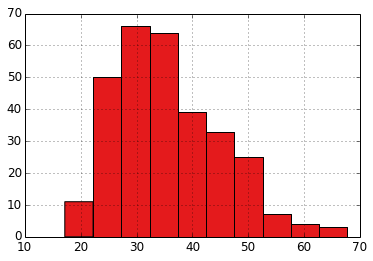

In [7]:
math.hist()

I'm going to tweak their threshold as my calculation is a bit miscalibrated.

In [8]:
(math > 32).value_counts()

True     182
False    120
dtype: int64

This is a bit closer but its hard to tell where the missing samples are.

In [9]:
(math > 31.5).value_counts()

True     191
False    111
dtype: int64

In [10]:
math_t = (math > 31.5).map({True:'MATH High', False:'MATH Low'})

# Survival Analysis

Curves look a little off, maybe I'm using more recent data?

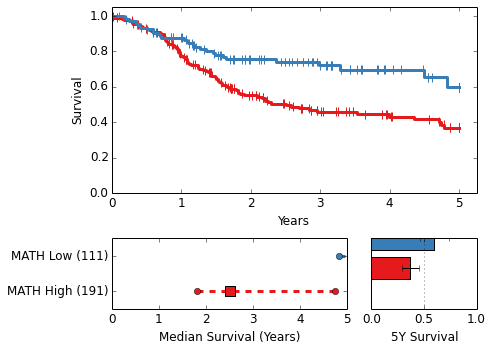

In [11]:
survival_and_stats(math_t, surv)

Combination of HPV and MATH  
Not sure why they cut off survival at 4 years

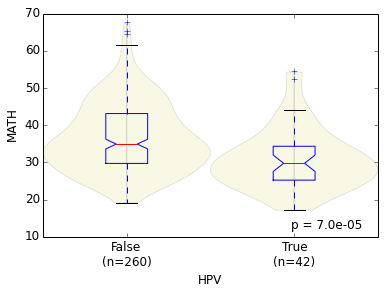

In [12]:
violin_plot_pandas(hpv, math)

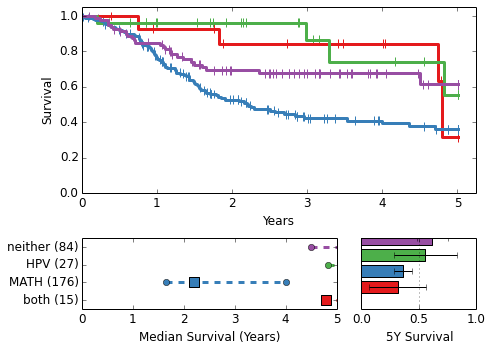

In [13]:
survival_and_stats(combine(math_t=='MATH High', hpv), surv)

From another angle, I don't see the HPV effect in my data. 

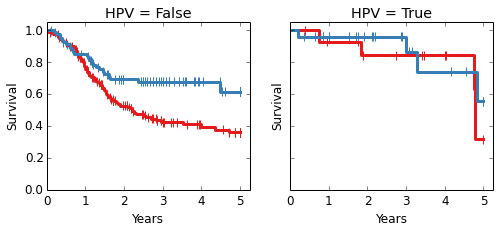

In [14]:
draw_survival_curves(math_t, surv, hpv)

### Combination Analysis in HPV-

* TP53-3p (Our finding from [this paper](http://www.nature.com/ng/journal/v46/n9/full/ng.3051.html)).
* I use a different working set with some old patients filtered

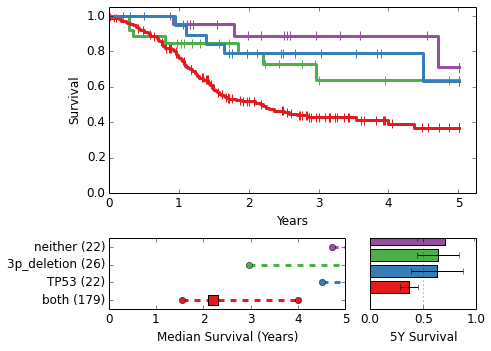

In [15]:
survival_and_stats(combine(del_3p<0, mut.features.ix['TP53']>0).ix[keepers_o].dropna(), 
                   clinical.survival.survival_5y)

This is with the old patients back in.

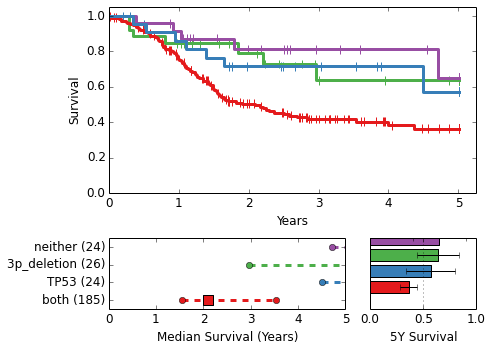

In [16]:
survival_and_stats(combine(del_3p<0, mut.features.ix['TP53']>0).ix[ti(hpv==False)].dropna(), 
                   clinical.survival.survival_5y)

TP53-MATH (Figure 6b) 

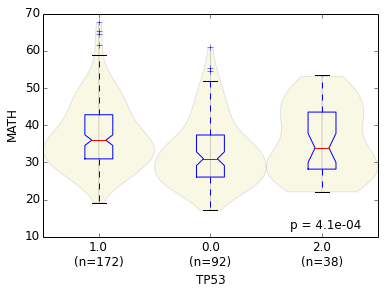

In [17]:
violin_plot_pandas(mut.df.ix['TP53'], math)

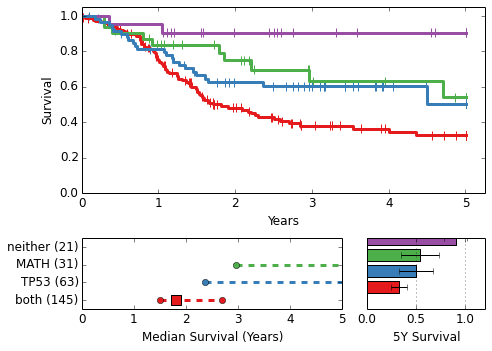

In [18]:
survival_and_stats(combine(math_t=='MATH High', mut.features.ix['TP53']>0).ix[ti(hpv==False)].dropna(), 
                   clinical.survival.survival_5y)

3p Deletion-MATH

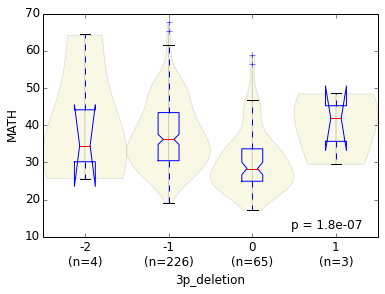

In [19]:
violin_plot_pandas(del_3p, math, order=[-2,-1,0,1])

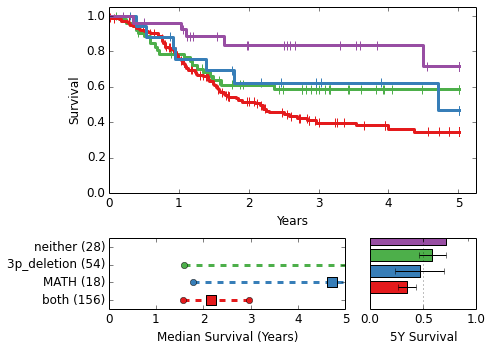

In [20]:
survival_and_stats(combine(math_t=='MATH High', del_3p < 0).ix[ti(hpv==False)].dropna(), 
                   clinical.survival.survival_5y)

TP53-3p combination + MATH

In [23]:
combo = combine(mut.features.ix['TP53']>0, del_3p < 0)

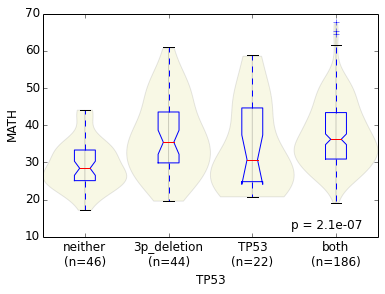

In [24]:
violin_plot_pandas(combo, math, order=['neither','3p_deletion',
                                       'TP53','both'])

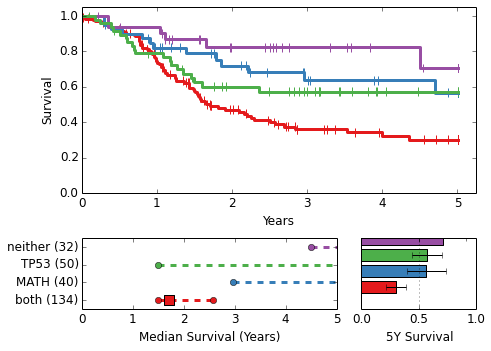

In [25]:
survival_and_stats(combine(math_t=='MATH High', combo=='both').ix[ti(hpv==False)].dropna(), 
                   clinical.survival.survival_5y)

TP53-3p combination in in the context of MATH

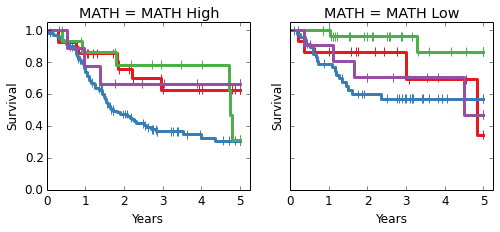

In [26]:
draw_survival_curves(combo, surv, math_t)

MATH in the context of TP53-3p

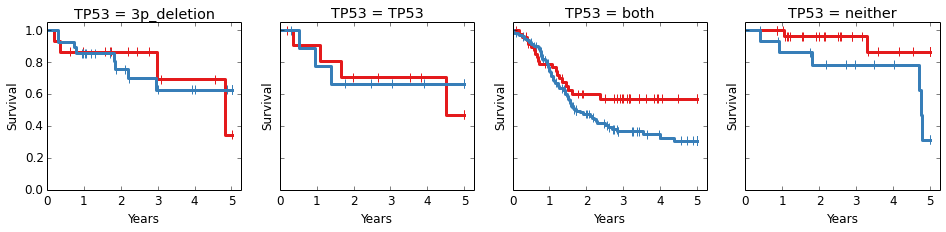

In [27]:
draw_survival_curves(math_t=='MATH High', surv, combo)

#### Add third subtype from out paper

In [28]:
two_hit = combine(del_3p<0, mut_new.ix['TP53']>0) == 'both'
two_hit.name = 'two_hit'
subtypes = combine(mirna.ix['hsa-mir-548k'][:,'01'] > -1, two_hit)
subtypes = subtypes.map({'hsa-mir-548k':1, 'neither':1, 'two_hit':2, 'both': 3})
subtypes.name = 'subtype'

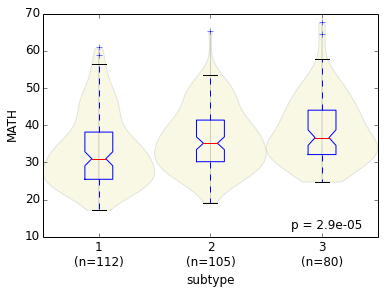

In [29]:
violin_plot_pandas(subtypes, math)

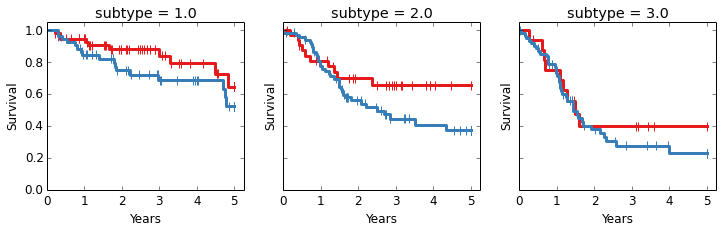

In [30]:
draw_survival_curves(math_t=='MATH High', surv, subtypes)

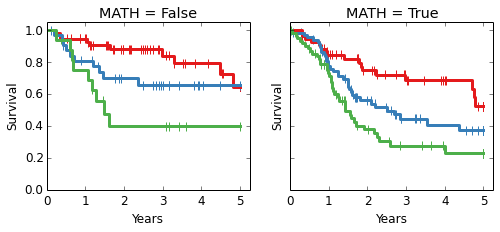

In [31]:
draw_survival_curves(subtypes, surv, math_t=='MATH High')